In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import pickle
import itertools
from collections import defaultdict
import networkx.algorithms.community as nx_comm

In [5]:
def get_followers_(user_id, access_token, with_name=False):
    fields = 'first_name,last_name' if with_name else ''
    url = 'https://api.vk.com/method/users.getFollowers?' + \
                        'user_id={}&count=1000&access_token={}&fields={}&v=5.131'.format(user_id, access_token, fields)
    response = requests.get(url).json()
    if response.get('error'):
        print(response.get('error'))
        return []
    return response.get('response').get('items')

In [6]:
def get_friends_(user_id, access_token, with_name=False):
    fields = 'first_name,last_name' if with_name else ''
    url = 'https://api.vk.com/method/friends.get?' + \
                'user_id={}&access_token={}&fields={}&v=5.131'.format(user_id, access_token, fields)
    response = requests.get(url).json()
    if response.get('error'):
        print(response.get('error'))
        return []
    return response.get('response').get('items')

In [24]:
CENTRAL_USER_ID = 1
followers = get_followers_(CENTRAL_USER_ID, access_token=ACCESS_TOKEN, with_name=True)

In [8]:
followers = {user_dict['id']: user_dict.get('first_name') + \
                ' ' + user_dict.get('last_name') for user_dict in followers}

In [26]:
followers.__len__()


1000

In [ ]:
graph = []

for user_id in list(followers.keys()):
    graph.append(get_friends_(user_id, access_token=ACCESS_TOKEN, with_name=True))

In [34]:
combined_graph = {}
for k, v in zip(followers, graph):
    combined_graph[k.get('id')] = v
    

In [111]:
name_mapping = {item['id']: '_'.join([item['first_name'], item['last_name']])  for item in followers}

In [116]:
name_mapping.update(
    {item['id']: '_'.join([item['first_name'], item['last_name']])  for _item in graph for item in _item}
)

In [120]:
graph[0][0]

{'id': 283861646,
 'track_code': 'fe84ea3exTdzVBoRJ5VK23IvnTznlk9P6w-j6Q0TB1UgqiqGPWKoXCFsd0cuxxfcQ7cGhDf9PFvyA7SHaWBY',
 'first_name': 'Efim',
 'last_name': 'Kuznetsov',
 'can_access_closed': True,
 'is_closed': False}

In [188]:
g = nx.Graph()
for user_id, user_friends in combined_graph.items():
    g.add_node(user_id)
    for other_user_id, other_user_friends in combined_graph.items():
        if user_id != other_user_id:
            common_friends = set([v.get('id') for v in user_friends]) & set([v.get('id') for v in other_user_friends])
            if len(common_friends) > 0:
                g.add_edge(user_id, other_user_id)
                

In [189]:
nx.set_node_attributes(g, name_mapping, 'names')

In [168]:
from copy import deepcopy

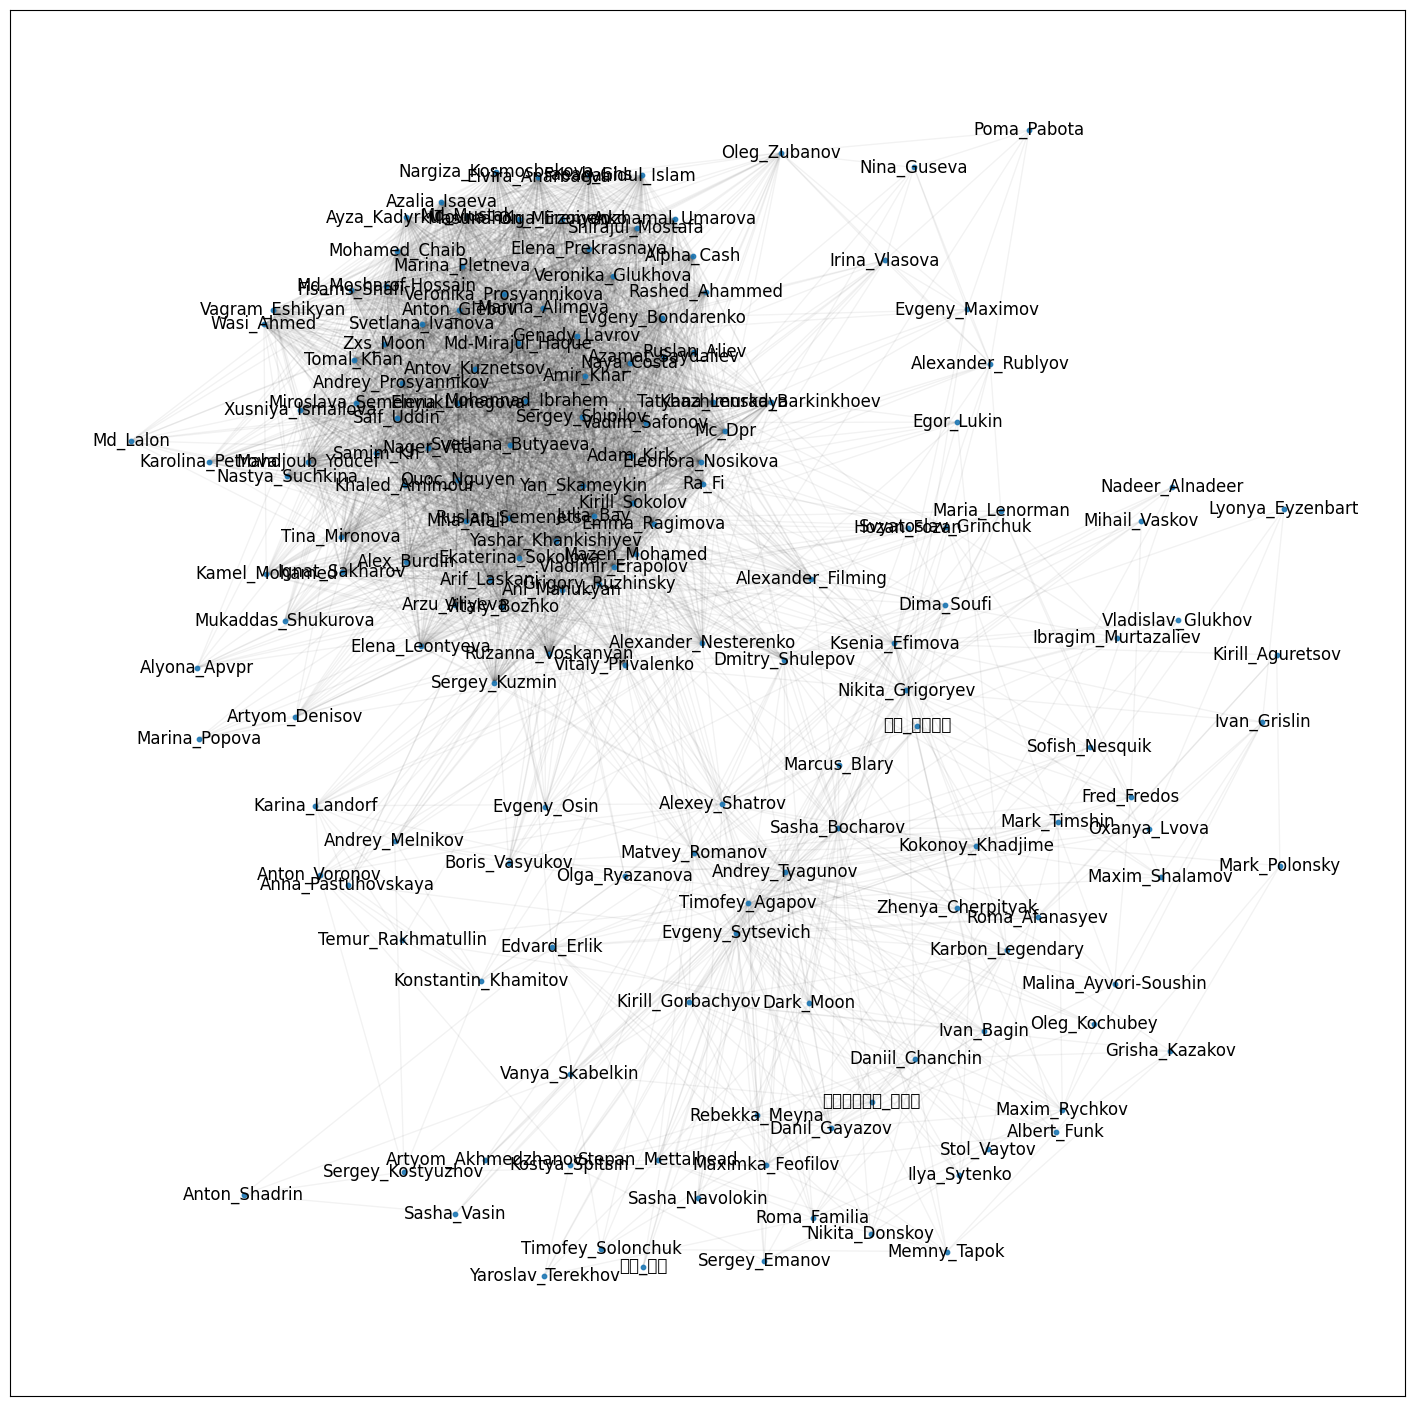

In [190]:
_g = deepcopy(g)
_g.remove_nodes_from([n for n, d in _g.degree() if not(5 < d)])

plt.figure(figsize=(18, 18))
pos = nx.kamada_kawai_layout(_g)
nx.draw_networkx_edges(_g, pos, width=1, alpha=0.05)
nx.draw_networkx_labels(_g, pos, labels={n: _g.nodes()[n].get('names') for n in _g.nodes}, alpha=1);
nx.draw_networkx_nodes(_g, pos, node_size=10, alpha=0.9)


In [192]:
with open('_g.pckl', 'wb') as file:
    pickle.dump(_g, file)

In [3]:
with open('_g.pckl', 'rb') as file:
    _g = pickle.load(file)

In [4]:
print('Number of nodes: ', nx.number_of_nodes(_g))
print('Number of edges: ', nx.number_of_edges(_g))
print('Radius: ', nx.radius(_g))
print('Diameter: ', nx.diameter(_g))
print('Average shortest path length: ', round(nx.average_shortest_path_length(_g), 2))
print('Average clustering coefficient: ', round(nx.average_clustering(_g), 2))

Number of nodes:  166
Number of edges:  3541
Radius:  3
Diameter:  4
Average shortest path length:  2.05
Average clustering coefficient:  0.69


## Clustering coefficient histogram

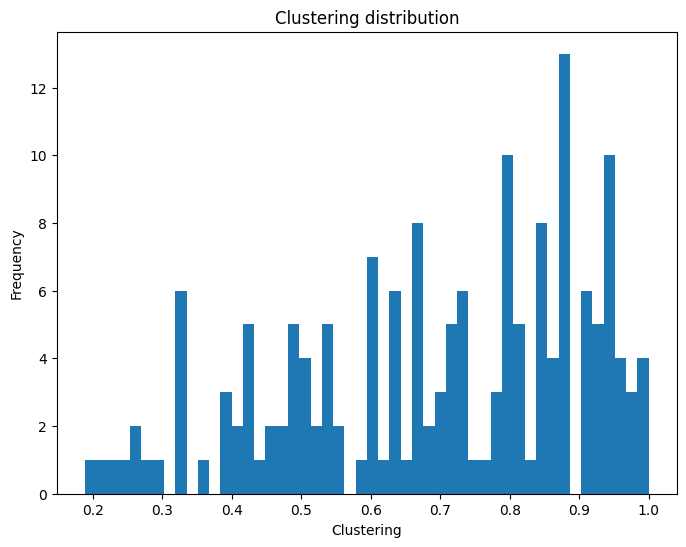

In [204]:
lcc = nx.clustering(_g)

norm = plt.Normalize(0, max(lcc.values()))

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(lcc.values(), bins=50)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency')
ax.set_title('Clustering distribution')

plt.show()

## Node Degree Distribution

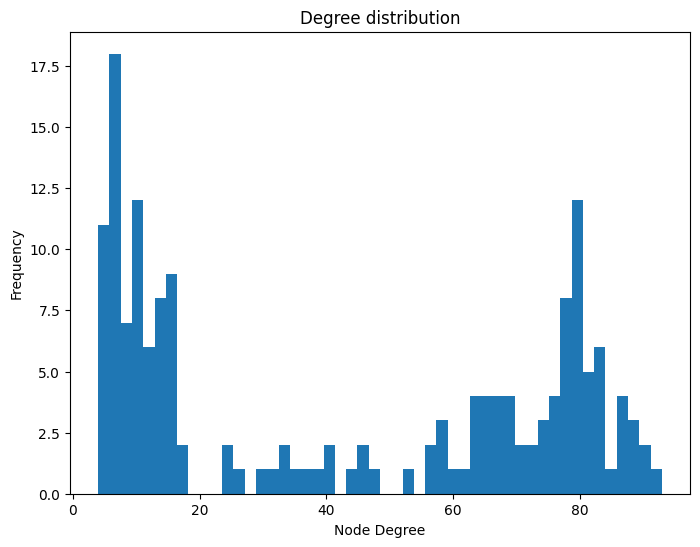

In [207]:
degrees = [_g.degree(n) for n in _g.nodes()]
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(degrees, bins=50)
ax.set_xlabel('Node Degree')
ax.set_ylabel('Frequency')
ax.set_title('Node Degree distribution')
plt.show()

## Degree/Closeness/Betweenness centralities, top nodes description.

In [208]:
def centralities(G: nx.Graph):
    cent = {}
    cent = {
        'degree': np.array(list(nx.degree_centrality(G).values())),
        'closeness': np.array(list(nx.closeness_centrality(G).values())),
        'betweenness': np.array(list(nx.betweenness_centrality(G).values()))
    }
    return cent

In [210]:
c = centralities(_g)

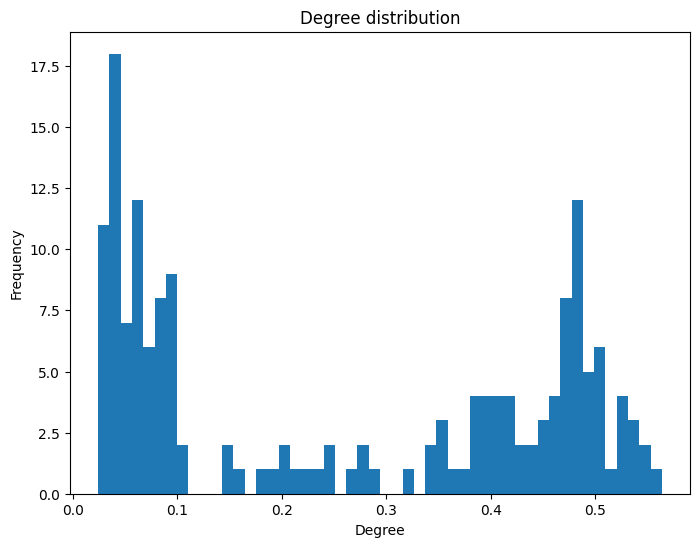

In [211]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(c['degree'], bins=50)    
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
ax.set_title('Degree distribution')
plt.show()

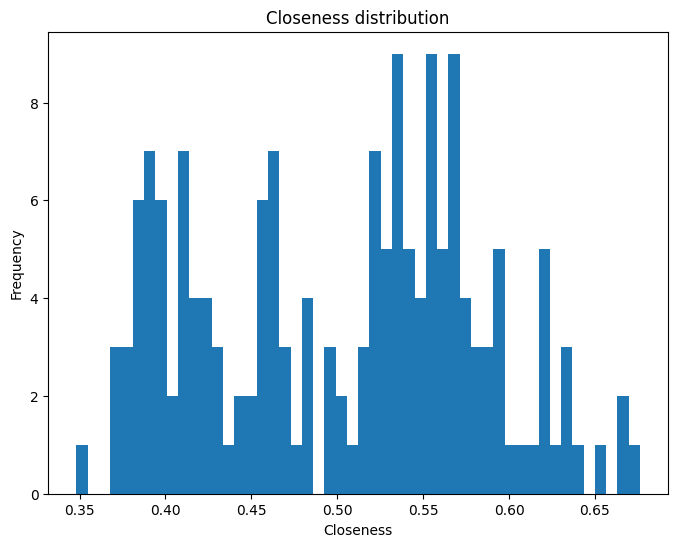

In [212]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(c['closeness'], bins=50)    
ax.set_xlabel('Closeness')
ax.set_ylabel('Frequency')
ax.set_title('Closeness distribution')
plt.show()

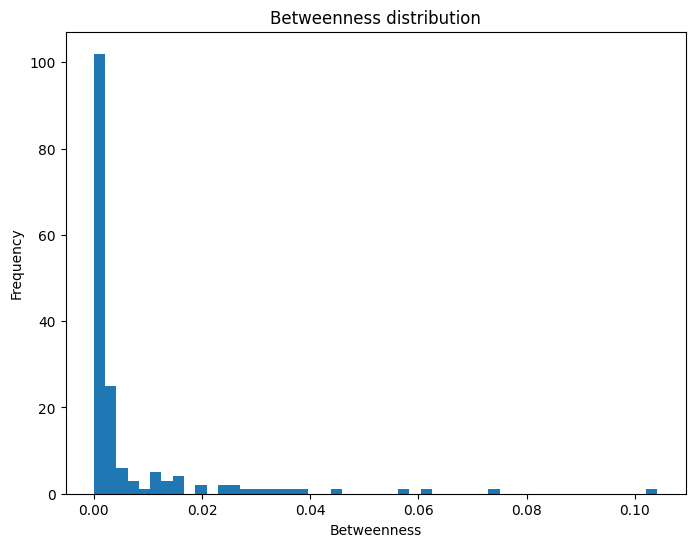

In [213]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(c['betweenness'], bins=50)    
ax.set_xlabel('Betweenness')
ax.set_ylabel('Frequency')
ax.set_title('Betweenness distribution')
plt.show()

## Top 10 centralities

In [219]:
def top10_centralities(G: nx.Graph):
    degree_cent = nx.degree_centrality(G)
    closeness_cent = nx.closeness_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    name = []
    degree_centrality = []
    closeness_centrality = []
    betweenness_centrality = []
    for node in G.nodes:
        name.append(G.nodes[node]['names'])
        degree_centrality.append(degree_cent[node])
        closeness_centrality.append(closeness_cent[node])
        betweenness_centrality.append(betweenness_cent[node])
    df_degree_cent = pd.DataFrame(
        {
            'name': name,
            'centrality': degree_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(10)
    df_closeness_cent = pd.DataFrame(
        {
            'name': name,
            'centrality': closeness_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(10)
    df_betweenness_cent = pd.DataFrame(
        {
            'name': name,
            'centrality': betweenness_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(10)
    top10 = {
        'degree': df_degree_cent,
        'closeness': df_closeness_cent,
        'betweenness': df_betweenness_cent
    }
    return top10

Following code makes a visualization: for each centrality it prints a top 10 table and graph, where the node size and color correspond to the centrality value.

In [222]:
top_dfs = top10_centralities(_g)

Degree centrality


name  centrality
7      Kirill_Sokolov    0.563636
9           Adam_Kirk    0.551515
44  Vladimir_Erapolov    0.545455
35      Mazen_Mohamed    0.539394
27      Emma_Ragimova    0.533333
81    Ruslan_Semenets    0.533333
1   Grigory_Ruzhinsky    0.527273
94          Julia_Bay    0.527273
61      Yan_Skameykin    0.527273
23  Svetlana_Butyaeva    0.521212

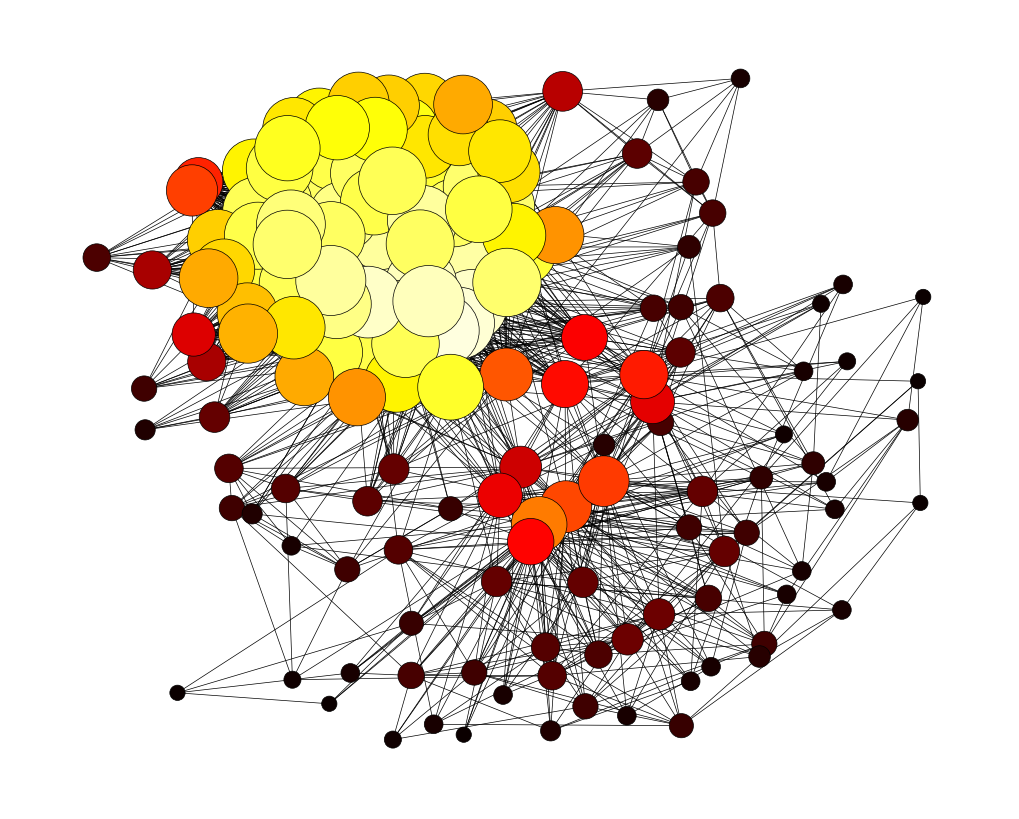

Closeness centrality


name  centrality
35       Mazen_Mohamed    0.676230
1    Grigory_Ruzhinsky    0.665323
27       Emma_Ragimova    0.665323
44   Vladimir_Erapolov    0.654762
72   Vitaly_Privalenko    0.639535
40  Ekaterina_Sokolova    0.634615
94           Julia_Bay    0.634615
7       Kirill_Sokolov    0.632184
19   Eleonora_Nosikova    0.629771
81     Ruslan_Semenets    0.622642

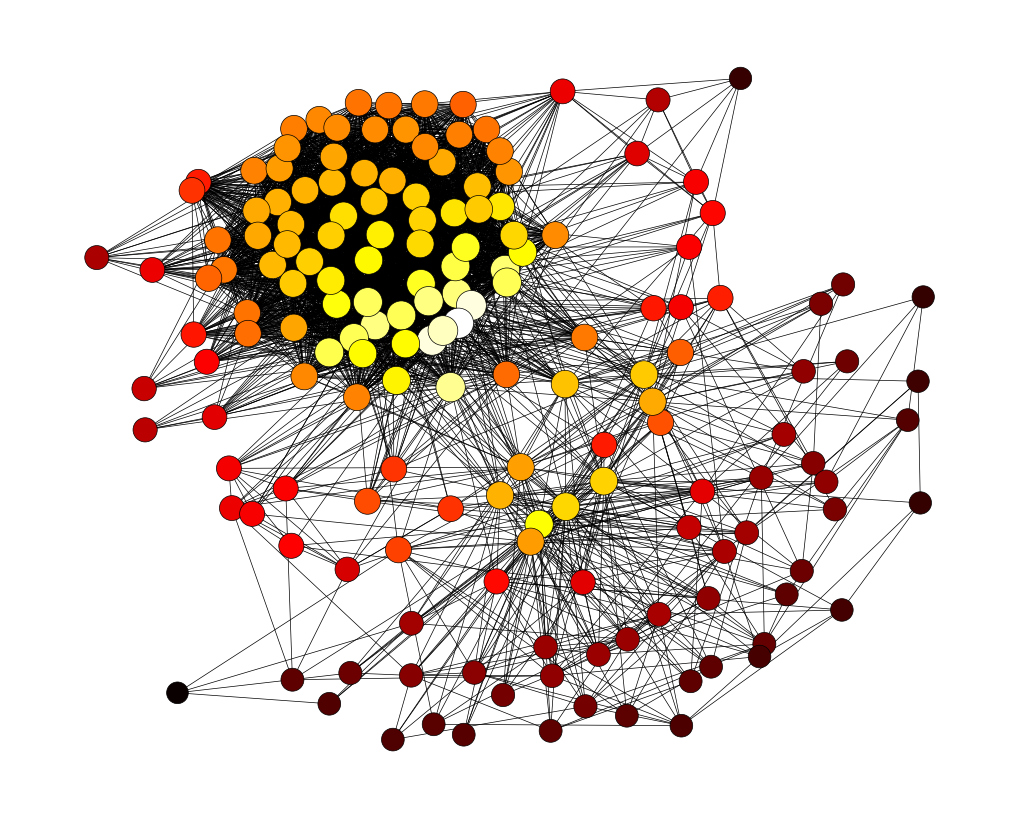

Betweenness centrality


name  centrality
108     Timofey_Agapov    0.104207
12      Sasha_Bocharov    0.074875
10     Andrey_Tyagunov    0.060990
15      Ksenia_Efimova    0.056798
72   Vitaly_Privalenko    0.045838
113     Matvey_Romanov    0.037877
6      Dmitry_Shulepov    0.036551
35       Mazen_Mohamed    0.033471
4     Nikita_Grigoryev    0.031901
44   Vladimir_Erapolov    0.030443

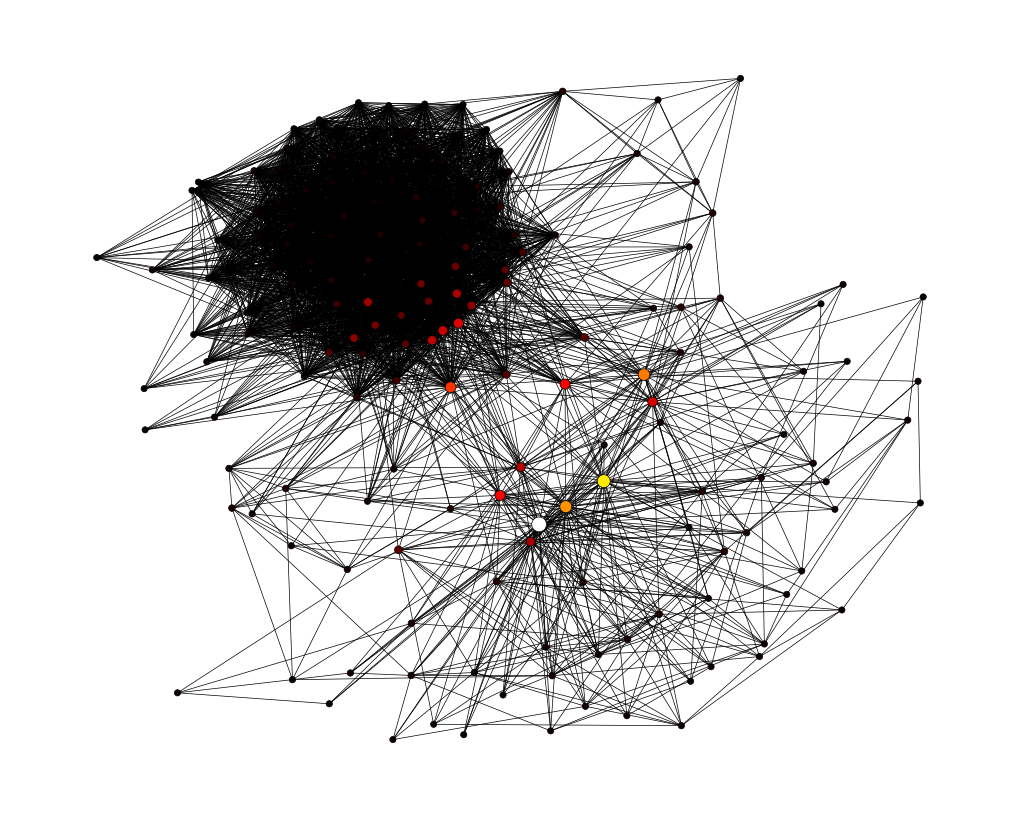

In [223]:
cases = [['degree', 5000, 0, 'Degree centrality'], 
         ['closeness', 700, 0, 'Closeness centrality'], 
         ['betweenness', 900, 20, 'Betweenness centrality']]
for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key])
    plt.figure(figsize=(10, 8))
    nx.draw(_g, 
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    plt.show()

## PageRank

In [227]:
def page_rank(G, alpha, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return rank / rank.sum()

In [228]:
def transition_matrix(A):
    A_sum = A.sum(1)[:, None]
    A_sum[A_sum == 0] = 1
    return A / A_sum

In [229]:
def teleportation_vector(A):
    return np.ones(A.shape[0]) / A.shape[0]

In [232]:
def update_rank(rank, P, v, alpha):
    return alpha*P.T@rank + (1-alpha)*v

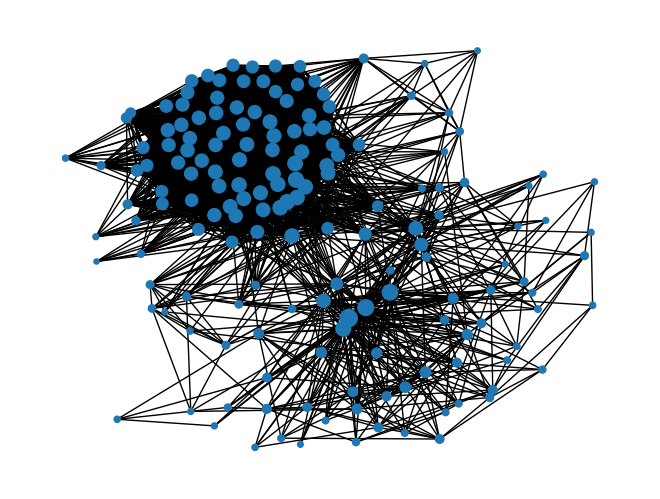

In [239]:
pr = page_rank(_g, 0.9, 100)
nx.draw_kamada_kawai(
    _g,
    node_size=(pr * 1e4)
)
plt.show()

## Clique search

Number of cliques with length > 50:  42


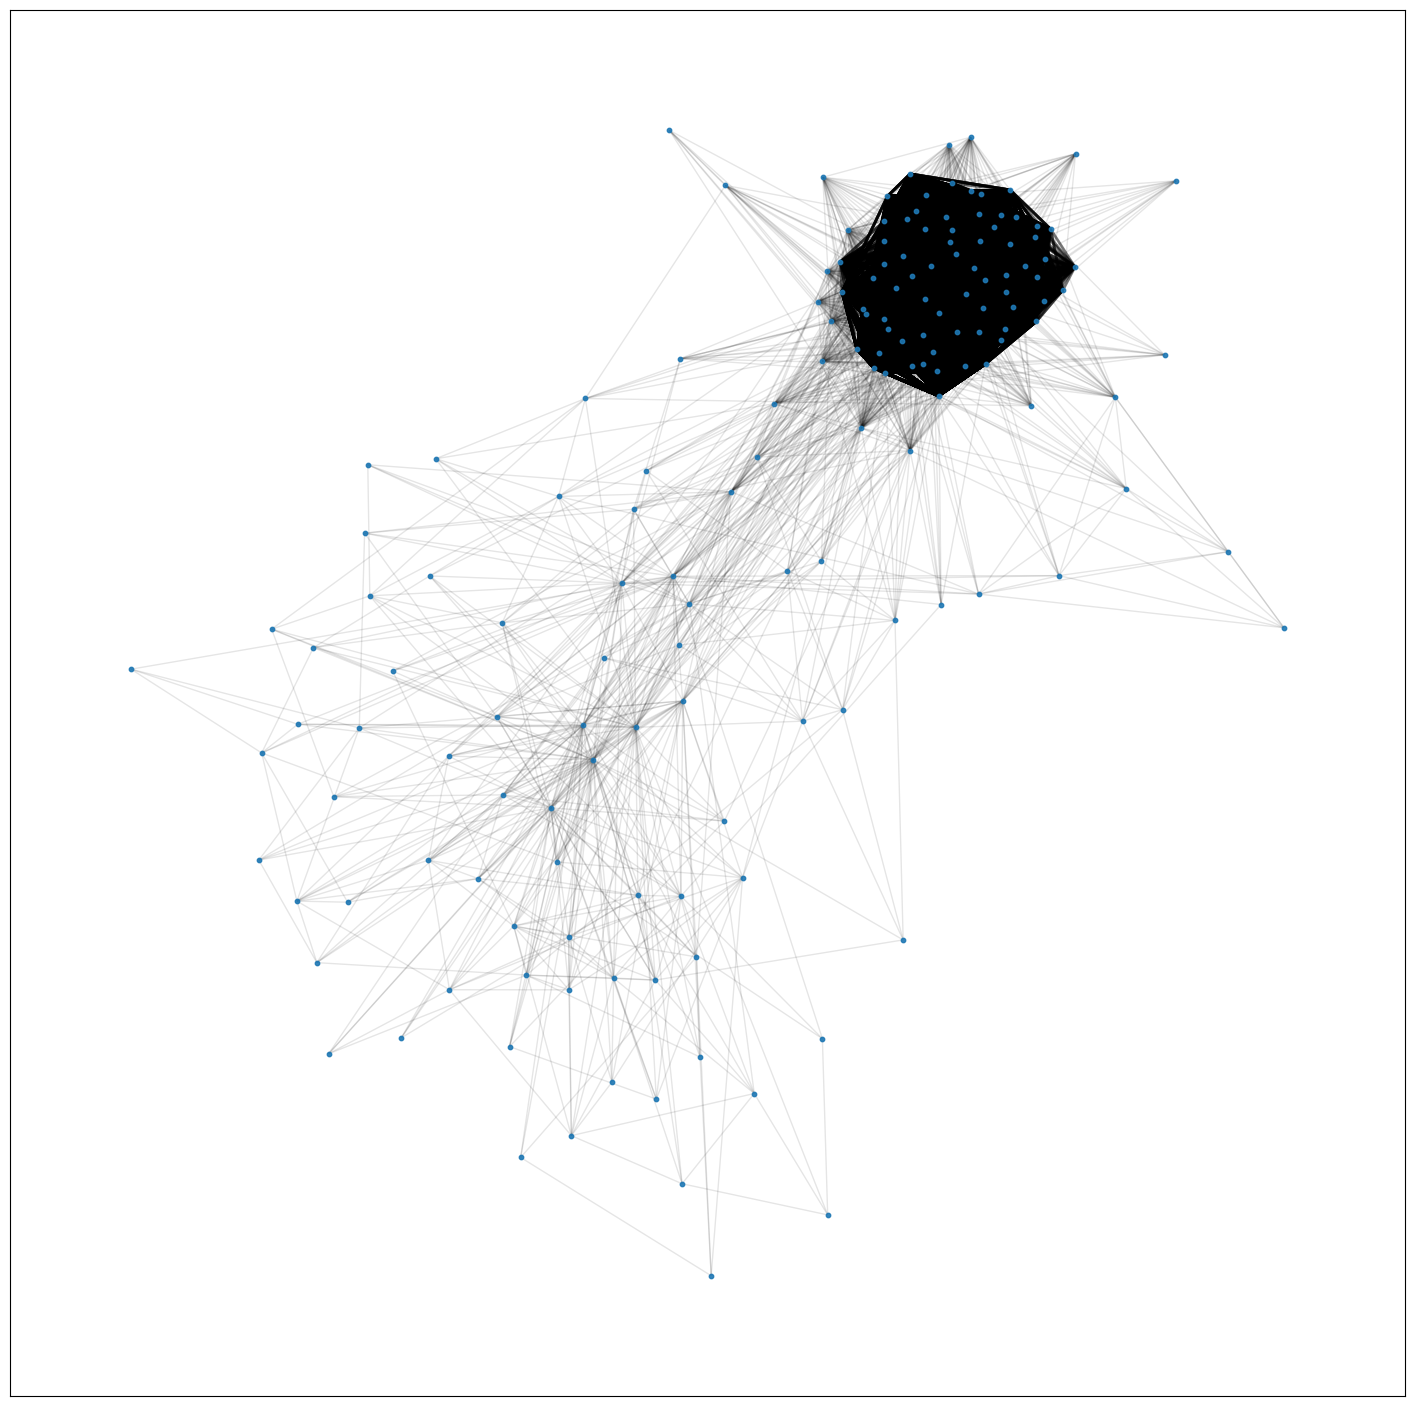

In [248]:
# clique search
cliques = nx.find_cliques(_g)
cliques = [clique for clique in cliques if len(clique) > 50]
print('Number of cliques with length > 50: ', len(cliques))
# visualize cliques
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(_g)
nx.draw_networkx_edges(_g, pos, width=1, alpha=0.1)
nx.draw_networkx_nodes(_g, pos, node_size=10, alpha=0.9)
for clique in cliques:
    nx.draw_networkx_edges(_g, pos, edgelist=list(itertools.combinations(clique, 2)), width=2, alpha=0.5)
plt.show()

## k cores visualization

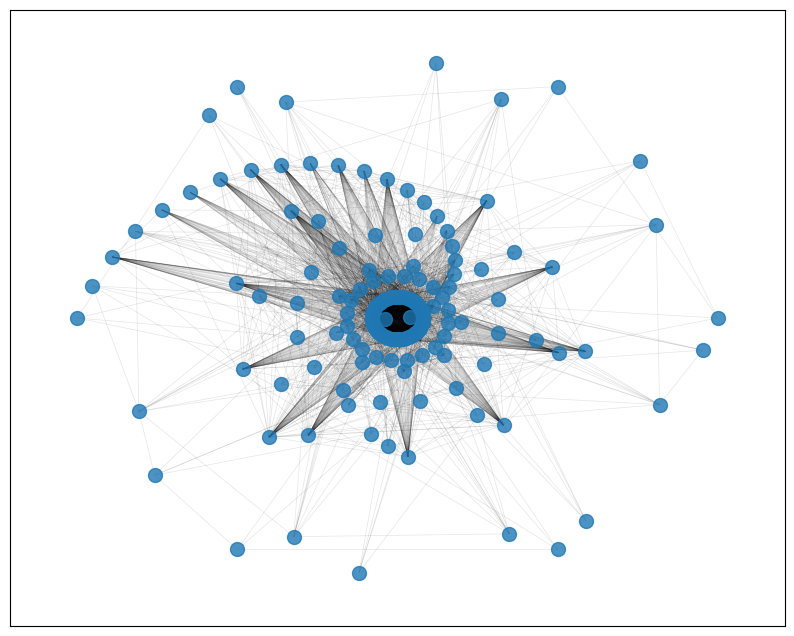

In [264]:
kcores = defaultdict(list)
for n, k in nx.core_number(_g).items():
    kcores[k].append(n)
pos = nx.layout.shell_layout(_g, list(kcores.values()))
plt.figure(figsize=(10, 8))
for kcore, nodes in kcores.items():
    nx.draw_networkx_nodes(_g, pos, nodelist=nodes, node_size=100, alpha=0.8)
nx.draw_networkx_edges(_g, pos, width=0.5, alpha=0.1)
plt.show()

# Community detection algorithms

## Girvan Newman

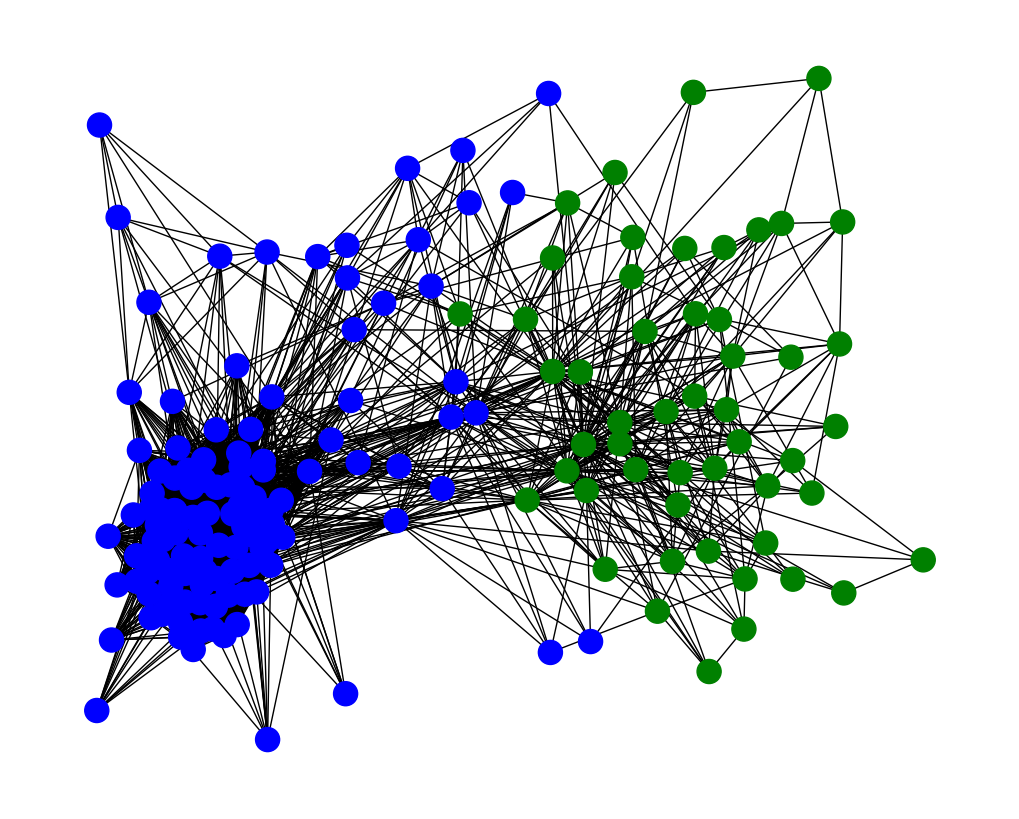

In [5]:
communities = nx.community.girvan_newman(_g)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

color_map = []
for node in _g:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

plt.figure(figsize=(10, 8))
nx.draw(_g, node_color=color_map)
plt.show()

In [6]:
round(nx_comm.modularity(_g, node_groups), 2)

0.13

## Label Propagation algorithm

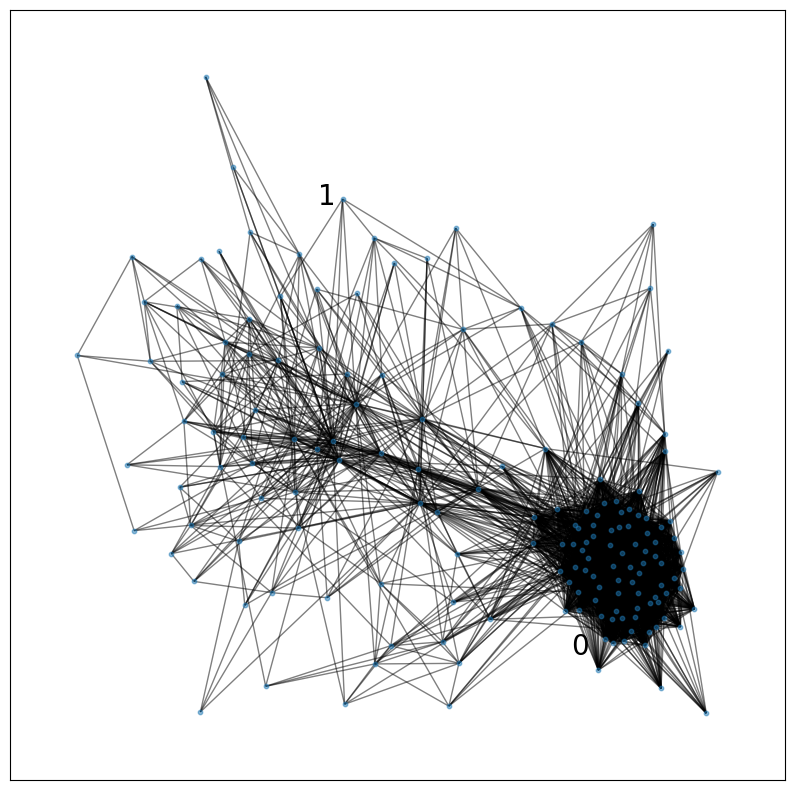

In [10]:
labels = nx.algorithms.community.label_propagation.label_propagation_communities(_g)
labels = list(labels)
# visulalize the communities
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx(_g, node_size=10, alpha=0.5, ax=ax, with_labels=False)
pos = nx.spring_layout(_g)
for i, label in enumerate(labels):
    x, y = np.mean(np.array([pos[node] for node in label]), axis=0)
    ax.text(x, y, str(i), fontsize=20)
plt.show()

In [11]:
round(nx_comm.modularity(_g, labels), 2)

0.15